In [1]:
%load_ext lab_black
%load_ext autotime
%load_ext autoreload
import numpy as np
import pandas as pd

time: 254 ms (started: 2022-09-15 22:59:13 -07:00)


The [COIL-20 Columbia Object Image Library](http://www.cs.columbia.edu/CAVE/software/softlib/coil-20.php): 1440 grayscale images at a 128 x 128 resolution (= 16384 features) -- 20 objects with 72 poses each.

## Read the zip file

In [2]:
import zipfile
from io import BytesIO

import requests

url = "http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip"
req = requests.get(url, timeout=10)

zip_file = zipfile.ZipFile(BytesIO(req.content))

time: 1.64 s (started: 2022-09-15 22:59:13 -07:00)


In [3]:
zip_file.infolist()[:10]

[<ZipInfo filename='coil-20-proc/obj10__1.png' filemode='-rw-rw-rw-' file_size=11089>,
 <ZipInfo filename='coil-20-proc/obj10__10.png' filemode='-rw-rw-rw-' file_size=9070>,
 <ZipInfo filename='coil-20-proc/obj10__11.png' filemode='-rw-rw-rw-' file_size=8643>,
 <ZipInfo filename='coil-20-proc/obj10__12.png' filemode='-rw-rw-rw-' file_size=8328>,
 <ZipInfo filename='coil-20-proc/obj10__13.png' filemode='-rw-rw-rw-' file_size=7951>,
 <ZipInfo filename='coil-20-proc/obj10__14.png' filemode='-rw-rw-rw-' file_size=7711>,
 <ZipInfo filename='coil-20-proc/obj10__15.png' filemode='-rw-rw-rw-' file_size=7518>,
 <ZipInfo filename='coil-20-proc/obj10__16.png' filemode='-rw-rw-rw-' file_size=7312>,
 <ZipInfo filename='coil-20-proc/obj10__17.png' filemode='-rw-rw-rw-' file_size=7225>,
 <ZipInfo filename='coil-20-proc/obj10__18.png' filemode='-rw-rw-rw-' file_size=7166>]

time: 7.87 ms (started: 2022-09-15 22:59:15 -07:00)


This is un-necessary, as the entire zip file is just the PNG images (no `README` or folders), but in case that ever changes, let's just keep the PNGs:

In [4]:
zip_infos = [
    zip_info
    for zip_info in zip_file.infolist()
    if not zip_info.is_dir() and zip_info.filename.endswith(".png")
]

time: 2.34 ms (started: 2022-09-15 22:59:15 -07:00)


Before reading the files, create a numpy `ndarray` that can store the image data:

In [5]:
n_objects = 20
n_poses = 72
nx = 128
ny = 128
n_features = nx * ny
img_data = np.empty([n_objects * n_poses, n_features], dtype=int)
img_data.shape

(1440, 16384)

time: 5.99 ms (started: 2022-09-15 22:59:15 -07:00)


Also some notes on the filename that we will need to know:

* filename is of the form `coil-20-proc/obj11__34.png`
* The directory name is uninformative so we can ignore that.
* `obj11` => object id is 11
* `__34` => pose id is 34

Also, you can't tell this by looking at just one example file, but:

* object id is 1-indexed...
* but the pose_id is 0-indexed

An odd choice but we can work with it.

In [6]:
import PIL.Image

for zip_info in zip_infos:
    _, png_filename = zip_info.filename.split("/")
    object_id, pose_id = png_filename.split("__")
    object_id = int(object_id[3:])
    pose_id = int(pose_id[:-4])
    # then convert to 1D row index of output data
    idx = (object_id - 1) * n_poses + pose_id
    with zip_file.open(zip_info.filename) as png_file:
        img = PIL.Image.open(png_file)
        img_data[idx, :] = list(img.getdata())

time: 1.46 s (started: 2022-09-15 22:59:15 -07:00)


In [7]:
img_data[0], img_data[-1]

(array([4, 4, 4, ..., 4, 4, 4]), array([0, 0, 0, ..., 0, 0, 0]))

time: 4.33 ms (started: 2022-09-15 22:59:16 -07:00)


Don't forget to close the zip file:

In [8]:
zip_file.close()

time: 1.87 ms (started: 2022-09-15 22:59:16 -07:00)


## View object image

In [9]:
import matplotlib.pyplot as plt


def show_coil20_object(coil20, obj, pose):
    if not 0 <= obj < 20:
        raise ValueError("obj should be a value in [0, 19]")
    n_poses = 72
    if not 0 <= pose < n_poses:
        raise ValueError("pose should be a value in [0, 71]")
    idx = obj * n_poses + pose
    nx = 128
    ny = 128
    if coil20.shape[1] != nx * ny:
        raise ValueError(f"coil20 image should be {nx} x {ny}")
    plt.imshow(
        coil20[idx].reshape((ny, nx)),
        cmap=plt.cm.gray,
        interpolation="nearest",
        vmin=0,
        vmax=255,
    )

time: 487 ms (started: 2022-09-15 22:59:16 -07:00)


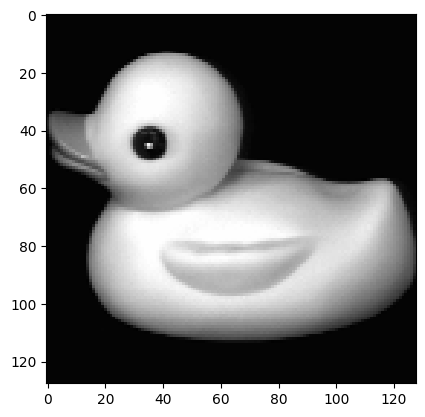

time: 169 ms (started: 2022-09-15 22:59:17 -07:00)


In [10]:
show_coil20_object(img_data, 0, 0)

## Pipeline

In [11]:
from drnb.util import categorize

target = pd.DataFrame(
    dict(
        pose_id=list(range(n_poses)) * n_objects,
        object_id=np.repeat(range(n_objects), n_poses),
    )
)
categorize(target, "object_id")
target

,pose_id,object_id
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1435,67,19
1436,68,19
1437,69,19
1438,70,19


time: 18.9 ms (started: 2022-09-15 22:59:17 -07:00)


In [14]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "coil20",
    data=img_data,
    target=target,
    tags=["small", "image", "vhighdim"],
    url="https://www.cs.columbia.edu/CAVE/software/softlib/coil-20.php",
    verbose=True,
)

[23:00:40] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=177662;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=564268;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#392\392]8;;\

           INFO     Initial data shape: (1440, 16384)                                                ]8;id=169363;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=564309;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#80\80]8;;\

           INFO     Keeping all columns                                                            ]8;id=598272;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=119790;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Data shape after filtering columns: (1440, 16384)                               ]8;id=246663;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=325022;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#151\151]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=527411;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=929807;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#135\135]8;;\

           INFO     Data shape after filtering NAs: (1440, 16384)                                   ]8;id=426541;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=575135;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

[23:00:41] INFO     Checked for duplicates: found 0                                                 ]8;id=114380;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=883920;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     No scaling                                                                     ]8;id=681369;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=486307;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=121047;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=511947;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#163\163]8;;\

           INFO     Writing data for coil20                                                         ]8;id=989781;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=663866;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[23:00:49] INFO     Processing target with initial shape (1440, 2)                                  ]8;id=935599;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=863641;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#196\196]8;;\

           INFO     Keeping all columns                                                            ]8;id=281828;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=513147;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Writing target for coil20                                                       ]8;id=759338;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=830599;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=60702;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=875984;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#240\240]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=67526;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=433354;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

[23:00:51] INFO     Calculating triplets                                                            ]8;id=154884;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=87612;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#276\276]8;;\

           INFO     Writing csv format to triplets/coil20.5.1337.idx.csv                            ]8;id=846915;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=725543;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

           INFO     Writing csv format to triplets/coil20.5.1337.l2.csv                             ]8;id=155834;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=530927;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

           INFO     Writing numpy format to triplets/coil20.5.1337.idx.npy                          ]8;id=216162;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=944036;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing numpy format to triplets/coil20.5.1337.l2.npy                           ]8;id=433665;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=557255;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing pipeline result for coil20                                              ]8;id=517653;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=196118;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#128\128]8;;\

time: 11.2 s (started: 2022-09-15 23:00:40 -07:00)
